In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

import cv2
sns.set_theme(style="darkgrid", palette="pastel")

In [17]:
base_train_dir = "kaggle/working/data/images/train"
base_test_dir = "kaggle/working/data/images/val"

base_label_train_dir = "kaggle/working/data/labels/train"
base_label_test_dir = "kaggle/working/data/labels/val"

train_dirs = os.listdir(base_train_dir)
test_dirs = os.listdir(base_test_dir)

In [18]:
df_train = pd.DataFrame({"path":train_dirs})
df_test = pd.DataFrame({"path":test_dirs})

In [19]:
df_train.head()

path
0  vid_4_10100.jpg
1  vid_4_21540.jpg
2  vid_4_14160.jpg
3   vid_4_9240.jpg
4   vid_4_3460.jpg

In [20]:
# Функция для извлечения статистик изображения
def extract_image_statistics(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    # Преобразуем в RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    mean = np.mean(img, axis=(0, 1))  # Среднее значение по каждому каналу (R, G, B)
    return [mean[0], mean[1], mean[2], width, height]


def extract_bounding_box_features(label_path, image_width, image_height):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    for line in lines:
        parts = line.strip().split()
        
        class_id = int(parts[0])  
        x_center = float(parts[1]) * image_width  # Нормализованный x центр -> реальная координата
        y_center = float(parts[2]) * image_height  # Нормализованный y центр -> реальная координата
        width = float(parts[3]) * image_width  # Нормализованная ширина -> реальная ширина
        height = float(parts[4]) * image_height  # Нормализованная высота -> реальная высота
        area = width * height
        
    
    return [class_id, x_center, y_center, width, height, area]

In [21]:
res = extract_image_statistics(base_train_dir + "/"+"vid_4_10000.jpg")

In [22]:
df_train['res'] = df_train['path'].apply(lambda x: extract_image_statistics(Path(base_train_dir,x)))
df_test['res'] = df_test['path'].apply(lambda x: extract_image_statistics(Path(base_test_dir,x)))

In [23]:
columns = ["mean_r","mean_g","mean_b","width","height"]

df_train_expanded = df_train.res.apply(pd.Series)
df_test_expanded = df_test.res.apply(pd.Series)

df_train_expanded.columns = columns
df_test_expanded.columns = columns

df_train = pd.concat([df_train,df_train_expanded],axis=1).drop(columns="res")
df_test = pd.concat([df_test,df_test_expanded],axis=1).drop(columns="res")

In [24]:
df_train['res_labels'] = df_train['path'].apply(lambda x: extract_bounding_box_features(Path(base_label_train_dir,x).with_suffix('.txt'),676,380))
df_test['res_labels'] = df_test['path'].apply(lambda x: extract_bounding_box_features(Path(base_label_test_dir,x).with_suffix('.txt'),676,380))

In [25]:
bbox_columns = ['class_id', 'x_center', 'y_center', 'width_bbox', 'height_bbox', 'area_bbox']

df_train_expanded_labels = df_train.res_labels.apply(pd.Series)
df_test_expanded_labels = df_test.res_labels.apply(pd.Series)

df_train_expanded_labels.columns = bbox_columns
df_test_expanded_labels.columns = bbox_columns

df_train = pd.concat([df_train,df_train_expanded_labels],axis=1).drop(columns="res_labels")
df_test = pd.concat([df_test,df_test_expanded_labels],axis=1).drop(columns="res_labels")

In [26]:
df_train.head()

path     mean_r      mean_g      mean_b  width  height  \
0  vid_4_10100.jpg  52.360067   72.972956   71.420547  676.0   380.0   
1  vid_4_21540.jpg  64.595656   81.177211   85.905687  676.0   380.0   
2  vid_4_14160.jpg  87.365778  100.043635  108.008899  676.0   380.0   
3   vid_4_9240.jpg  45.307521   75.576950   85.449607  676.0   380.0   
4   vid_4_3460.jpg  71.613061   92.447680   92.529216  676.0   380.0   

   class_id    x_center    y_center  width_bbox  height_bbox     area_bbox  
0       0.0  514.826339  196.571750  134.515195    71.891892   9670.551879  
1       0.0  642.248915  193.148327   67.502171    40.592021   2740.049508  
2       0.0   80.953690  237.408301  161.907381    85.096525  13777.755477  
3       0.0  220.081573  197.091159   61.051712    29.041451   1773.030279  
4       0.0   29.348770  218.334942   58.697540    55.752896   3272.557820

In [27]:
df_test.head()

path     mean_r      mean_g     mean_b  width  height  class_id  \
0  vid_4_19920.jpg  50.549879   74.222026  94.877118  676.0   380.0       0.0   
1   vid_4_1980.jpg  81.899000  100.541011  98.132381  676.0   380.0       0.0   
2    vid_4_600.jpg  63.823392   97.101390  98.918880  676.0   380.0       0.0   
3  vid_4_10520.jpg  66.374513   83.249354  90.762617  676.0   380.0       0.0   
4   vid_4_1880.jpg  74.160923   94.749054  89.190221  676.0   380.0       0.0   

     x_center    y_center  width_bbox  height_bbox    area_bbox  
0   26.658466  215.156049   53.316932    34.723295  1851.339547  
1  605.073806  202.685006  119.351664    51.840412  6187.239433  
2  347.293777  209.776384  121.308249    44.504504  5398.763509  
3   18.342981  214.911519   36.685962    39.124839  1435.332375  
4  629.041968  198.910071   93.916064    52.115508  4894.483407

In [28]:
len(df_test)

75

In [29]:
len(df_train)

280

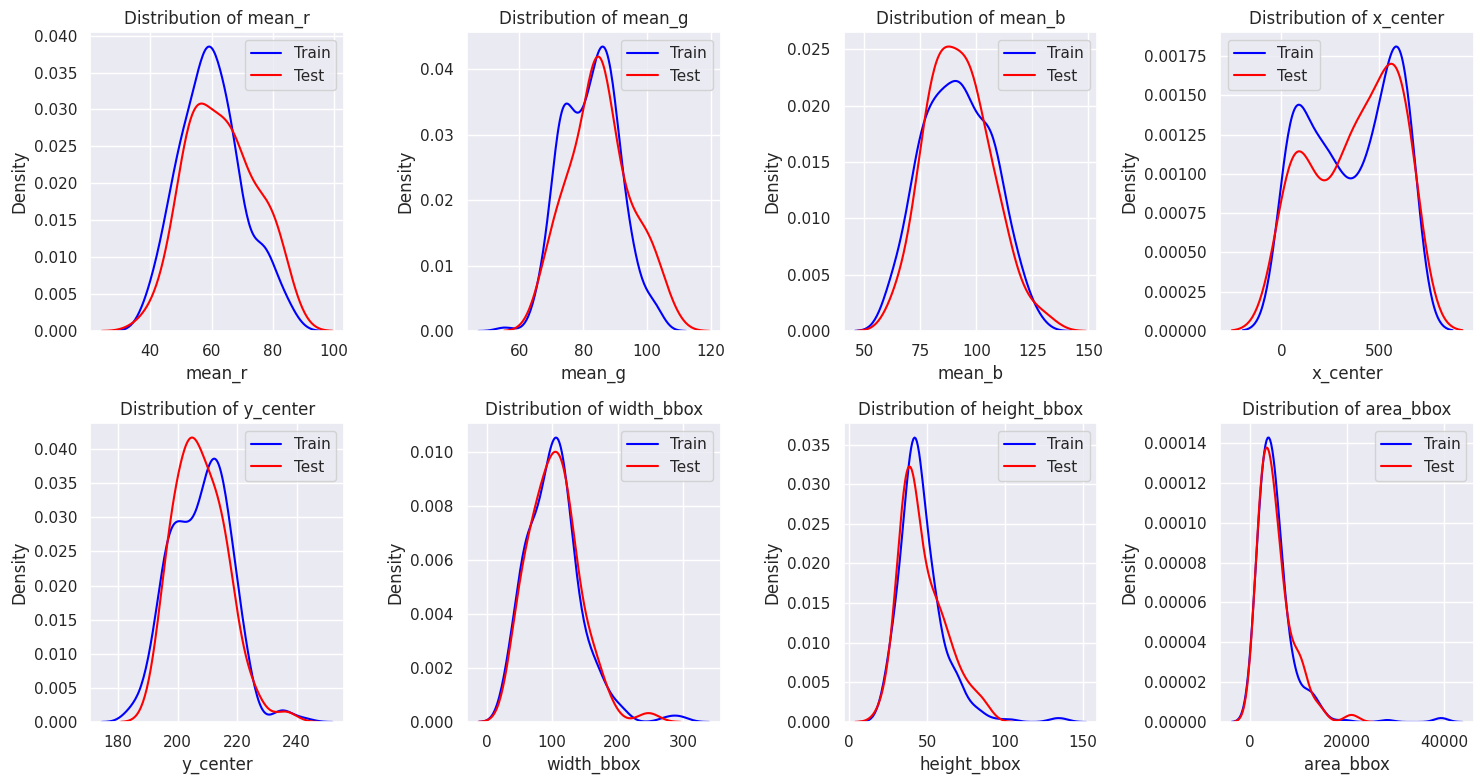

In [30]:
main_features  = ['mean_r', 'mean_g', 'mean_b','x_center', 'y_center', 'width_bbox', 'height_bbox', 'area_bbox' ]

fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # 2 ряда, 4 столбца

# Итерация по каждому столбцу и построение графиков
for i, col in enumerate(main_features):
    ax = axes[i // 4, i % 4]  # Получаем позицию на сетке (2 ряда по 4 графика)
    
    # Построение линий плотности для тренировочного и тестового наборов
    sns.kdeplot(df_train[col], color='blue', label='Train', ax=ax)
    sns.kdeplot(df_test[col], color='red', label='Test', ax=ax)
    
    # Заголовок и метки
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
    
    # Легенда
    ax.legend()

# Отображаем графики
plt.tight_layout()
plt.show()

In [31]:
from scipy.stats import ks_2samp, mannwhitneyu

In [32]:
for col in main_features:
    # Колмогоров-Смирнов тест
    ks_stat, ks_pvalue = ks_2samp(df_train[col], df_test[col])
    print(f'Feature {col} ks-test result  ---  statistic: {ks_stat}, p_value: {ks_pvalue}')
    
    # Манна-Уитни тест
    mw_stat, mw_pvalue = mannwhitneyu(df_train[col], df_test[col])

    print(f'Feature {col} mannwhitney result  ---  statistic: {mw_stat}, p_value: {mw_pvalue}')

Feature mean_r ks-test result  ---  statistic: 0.16071428571428573, p_value: 0.08301600233289964
Feature mean_r mannwhitney result  ---  statistic: 8818.0, p_value: 0.03314196452221132
Feature mean_g ks-test result  ---  statistic: 0.1442857142857143, p_value: 0.1524944342904272
Feature mean_g mannwhitney result  ---  statistic: 8909.0, p_value: 0.043897551927466964
Feature mean_b ks-test result  ---  statistic: 0.07952380952380952, p_value: 0.8151939311297162
Feature mean_b mannwhitney result  ---  statistic: 10365.0, p_value: 0.8646928968419466
Feature x_center ks-test result  ---  statistic: 0.11928571428571429, p_value: 0.3381982999664425
Feature x_center mannwhitney result  ---  statistic: 10195.5, p_value: 0.700126242095311
Feature y_center ks-test result  ---  statistic: 0.09142857142857143, p_value: 0.6665477470585011
Feature y_center mannwhitney result  ---  statistic: 10712.0, p_value: 0.788727996779249
Feature width_bbox ks-test result  ---  statistic: 0.05523809523809524, p

In [75]:
from sklearn.neighbors import LocalOutlierFactor

### Поиск шума и выбросов

In [78]:
def outliers_noise(data, feature, z_threshold=3):
    print(f"===== Analyzing {feature} =====")

    #используем z_score
    mean = data[feature].mean()
    std = data[feature].std()
    z_scores = (data[feature] - mean) / std
    noise_mask = np.abs(z_scores) > z_threshold
    outliers = data[noise_mask]

    ## используем Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)  # Уровень шума
    noise_mask = lof.fit_predict(data[[feature]]) == -1
    noise_data = data[noise_mask]

    exclude_indices  = outliers.index.union(noise_data.index)
    clean_data = data.loc[data.index.difference(exclude_indices)]

    print(f"Count of clean data {len(clean_data)}")
    print(f"Count of noise data {len(noise_data)}")
    print(f"Count of outliers {len(outliers)}")

    return clean_data, outliers, noise_data


In [80]:
len(df_train)

280

In [81]:
for feature in main_features[5:]:
    clean_data, outliers, noise_data = outliers_noise(df_train,feature)

===== Analyzing width_bbox =====
Count of clean data 252
Count of noise data 28
Count of outliers 3
===== Analyzing height_bbox =====
Count of clean data 252
Count of noise data 28
Count of outliers 4
===== Analyzing area_bbox =====
Count of clean data 252
Count of noise data 28
Count of outliers 4


###Поиск дрифта данных 